# MVP – Predição e Análise Estatística em Provas de 400m / 400m Hurdles

**Autor(a):** _Antônio Marcos Jander Chaboudt_  
**Matricula:** 4052024001511




## Mapa das Fases

1. **Definição do Problema e Hipóteses** – O que queremos prever/analisar e por quê.  
2. **Setup e Reprodutibilidade** – Seeds, versões, organização.  
3. **Carga de Dados via URL (ou local fallback)** – Requisito do trabalho.  
4. **Preparação e Limpeza** – Tipos, nulos, *features* a priori, criação de `event_id`.  
5. **EDA essencial** – Distribuições, tendências, desbalanceamento.  
6. **Split e Validação** – Hold-out temporal + GroupKFold por evento.  
7. **Trilha A – Classificação sem vazamento** – Baselines, tuning, avaliação robusta.  
8. **Análise Estatística Ampliada** – Usando `Rank`, `Result` e `Sec/Mtr/Pts`.  
9. **Trilha B – Diagnóstico pós-evento (com vazamento)** – Mostrar o que acontece ao incluir `Rank` e `Sec/Mtr/Pts`.  
10. **Regressão de `Sec/Mtr/Pts` (pré-evento)** – MAE, RMSE, R².  
11. **Checklist respondido** – Perguntas do enunciado.  
12. **Conclusões e próximos passos** – Síntese prática.


## 1) Definição do Problema e Hipóteses

- **Problema principal (Trilha A):** Prever **medalha (1) vs. não medalha (0)** antes da competição, usando atributos **a priori**: `Discipline`, `Gender`, `Age`, `Country`, `Host Country`, `Host Continent`, `# Participants`, `# Countries`, `# Continents`, `CompetitionSet`, `Comp.SetDetail`, `year`, `home_adv`.
- **Hipóteses:**  
  - *H1:* Contexto do evento e fatores demográficos afetam a chance de medalha.  
  - *H2:* Existe **vantagem de sede** (`home_adv`).  
  - *H3:* 400m Hurdles tem dinâmica distinta de 400m (controlado via `Discipline`).

> **Importante:** `Rank`, `Result` e `Sec/Mtr/Pts` são resultados **pós-evento**. Usá-los como **entradas** para prever medalha **causa vazamento**. No entanto, para análise **diagnóstica** (Trilha B), vamos **mostrá-los** como explicadores e quantificar o que muda.


## 2) Setup e Reprodutibilidade

- Seeds fixas para reprodutibilidade.  
- Impressão de versões de bibliotecas e recursos da máquina.  
- Organização em funções e *pipelines* (`ColumnTransformer`) para evitar vazamento e manter o código limpo.


In [1]:
# ==== Imports e ambiente ====
import os, io, time, sys, gc, math, itertools, warnings, platform, psutil, random, re
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             RocCurveDisplay, PrecisionRecallDisplay, average_precision_score,
                             f1_score, mean_absolute_error, mean_squared_error, r2_score)
from sklearn.linear_model import LogisticRegression, SGDClassifier, Ridge

from sklearn.dummy import DummyClassifier, DummyRegressor
from scipy import stats

warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

def _print_env():
    print("Python:", sys.version)
    print("Platform:", platform.platform())
    print("CPU cores:", psutil.cpu_count(logical=True))
    mem = psutil.virtual_memory()
    print("RAM total (GB):", round(mem.total/1024**3, 2))
    print("Pandas:", pd.__version__)
    import sklearn
    print("scikit-learn:", sklearn.__version__)

_print_env()


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Platform: Linux-6.6.97+-x86_64-with-glibc2.35
CPU cores: 2
RAM total (GB): 12.67
Pandas: 2.2.2
scikit-learn: 1.6.1


## 3) Carga de Dados via URL (e fallback local)

> **Requisito:** o dataset deve ser carregado via **URL pública** (ex.: link **RAW** do GitHub).  
> Como conveniência para testes, também suportamos **caminho local** no Colab.

Use **uma** das duas variáveis abaixo:
- `DATA_URL`: coloque seu link **RAW** do GitHub (ou download direto do Drive).  
- `LOCAL_PATH`: se estiver testando no Colab com arquivo no `/content`.


In [18]:
import requests

DATA_URL = "https://raw.githubusercontent.com/antoniochaboudt/MVP_Analise_de_dados/main/Dataset.xlsx"

def load_excel(path_or_url: str) -> pd.DataFrame:
    if path_or_url is None:
        raise ValueError("Forneça DATA_URL")
    if re.match(r"^https?://", str(path_or_url), flags=re.I):
        url = path_or_url
        if "github.com" in url and "/blob/" in url:
            url = url.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")
        print("Baixando dados de:", url)
        r = requests.get(url, timeout=60, allow_redirects=True)
        r.raise_for_status()
        ct = r.headers.get("Content-Type", "")
        if "text/html" in ct.lower():
            raise ValueError("A URL retornou HTML. Use o link RAW do GitHub ou um link de download direto.")
        return pd.read_excel(io.BytesIO(r.content), sheet_name=0, engine="openpyxl")
    else:
        print("Lendo dados locais de:", path_or_url)
        return pd.read_excel(path_or_url, sheet_name=0, engine="openpyxl")

path = DATA_URL if DATA_URL else LOCAL_PATH
df = load_excel(path)
print("Shape:", df.shape)
print("Colunas:", list(df.columns))
df.head(3)


Baixando dados de: https://raw.githubusercontent.com/antoniochaboudt/MVP_Analise_de_dados/main/Dataset.xlsx
Shape: (28630, 24)
Colunas: ['Date', 'Competition', 'CompetitionSet', 'Comp.SetDetail', 'Sport', 'Discipline', 'Gender', 'Class', 'Rank', 'Medal', 'Team Members', 'Person', 'Age', 'Country', 'Continent', 'Result', 'Sec/Mtr/Pts', 'Host City', 'Host Country', 'Host Continent', '# Participants', '# Countries', '# Continents', 'Rank Within Country']


,Date,Competition,CompetitionSet,Comp.SetDetail,Sport,Discipline,Gender,Class,Rank,Medal,...,Continent,Result,Sec/Mtr/Pts,Host City,Host Country,Host Continent,# Participants,# Countries,# Continents,Rank Within Country
0,2014-10-01,Asian Games,Asian Games,Asian Games,Athletics,400m Hurdles,Men,Seniors,1,G,...,Asia,49.71,49.71,Incheon,Republic of Korea,Asia,17,13,1,1
1,2014-10-01,Asian Games,Asian Games,Asian Games,Athletics,400m Hurdles,Men,Seniors,2,S,...,Asia,49.81,49.81,Incheon,Republic of Korea,Asia,17,13,1,1
2,2014-10-01,Asian Games,Asian Games,Asian Games,Athletics,400m Hurdles,Men,Seniors,3,B,...,Asia,50.29,50.29,Incheon,Republic of Korea,Asia,17,13,1,1


## 4) Preparação e Limpeza (sem vazamento)

- Conversão de tipos e datas.  
- Alvo binário `medal_bin` (1 se `Medal` ∈ {G,S,B}; 0 caso contrário).  
- Criação de `year` e `home_adv`.  
- **`event_id`** para agrupar por prova e evitar vazamento na validação.  
- Conversão robusta de `Rank` e `Sec/Mtr/Pts` para numéricos (podem vir com strings).


In [19]:
# ==== Preparação ====
# Datas
if not np.issubdtype(df['Date'].dtype, np.datetime64):
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Alvo binário
df['medal_bin'] = df['Medal'].isin(['G','S','B']).astype(int)

# Atributos a priori
df['year'] = df['Date'].dt.year
df['home_adv'] = (df['Country'] == df['Host Country']).astype(int)

# Conversões robustas
for col in ['Rank','Sec/Mtr/Pts']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Categoria de medalha (4 classes) para análises
df['MedalCat'] = df['Medal'].fillna('N')  # N = no medal

# event_id (por prova)
df['event_id'] = (df['Date'].dt.strftime('%Y-%m-%d') + "|" +
                  df['Competition'].astype(str) + "|" +
                  df['Gender'].astype(str) + "|" +
                  df['Discipline'].astype(str))

print("Proporção medalha:", df['medal_bin'].mean().round(4))
print("Nulos (%):")
print((df.isna().mean().sort_values(ascending=False)*100).round(2).head(12))

df.info()


Proporção medalha: 0.2441
Nulos (%):
Medal             75.59
Result             6.49
Sec/Mtr/Pts        6.49
Rank               3.95
Host Country       3.76
Host City          3.76
Host Continent     3.76
Comp.SetDetail     2.60
CompetitionSet     2.60
Age                1.29
Continent          0.01
Sport              0.00
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28630 entries, 0 to 28629
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 28630 non-null  datetime64[ns]
 1   Competition          28630 non-null  object        
 2   CompetitionSet       27887 non-null  object        
 3   Comp.SetDetail       27887 non-null  object        
 4   Sport                28630 non-null  object        
 5   Discipline           28630 non-null  object        
 6   Gender               28630 non-null  object        
 7   Class                28630 non-nu

## 5) EDA essencial

- Distribuição de medalhas por `Gender` e `Discipline`.  
- Tendência temporal da taxa de medalhas (para observar desbalanceamento).  
- Boxplots de `Sec/Mtr/Pts` por `MedalCat` (se disponível).  
- Histograma de `Rank` (se disponível).


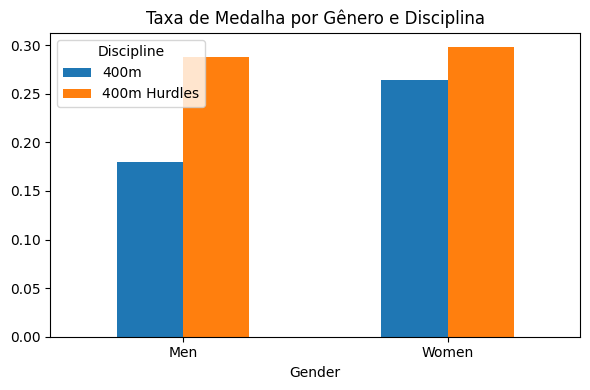

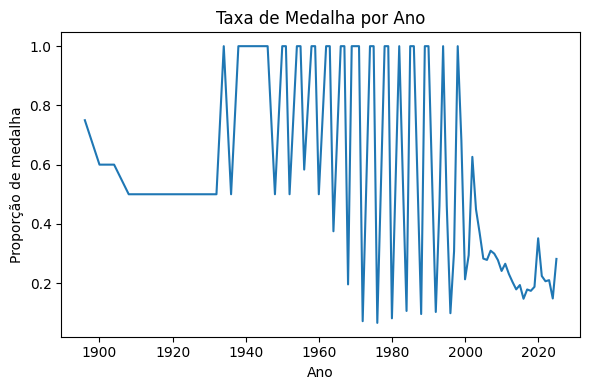

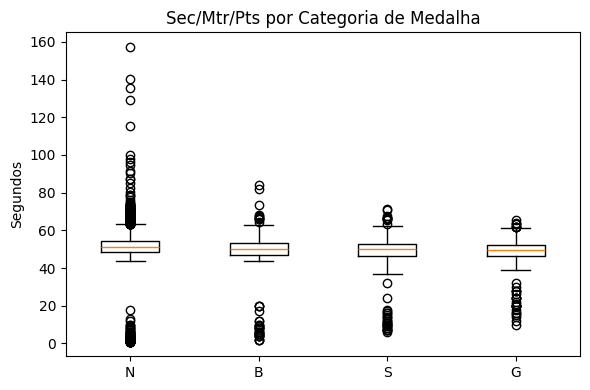

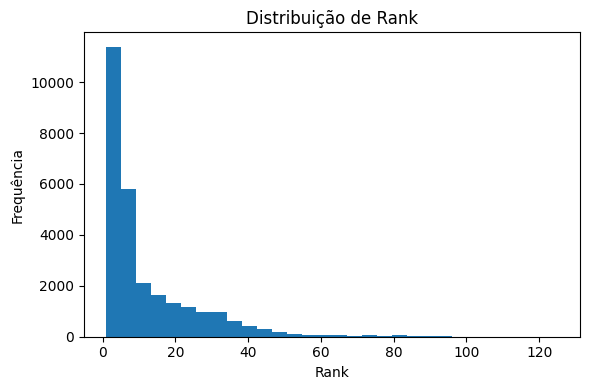

In [4]:
# ==== EDA ====
# Medalhas por gênero e disciplina
fig = plt.figure(figsize=(6,4))
medal_rate = df.groupby(['Gender','Discipline'])['medal_bin'].mean().unstack()
medal_rate.plot(kind='bar', rot=0, ax=plt.gca(), title='Taxa de Medalha por Gênero e Disciplina')
plt.tight_layout(); plt.show()

# Tendência temporal
fig = plt.figure(figsize=(6,4))
yr = df.groupby('year')['medal_bin'].mean()
yr.plot(title='Taxa de Medalha por Ano')
plt.xlabel('Ano'); plt.ylabel('Proporção de medalha')
plt.tight_layout(); plt.show()

# Boxplot de Sec/Mtr/Pts por MedalCat (se existir)
if 'Sec/Mtr/Pts' in df.columns:
    sub = df[['Sec/Mtr/Pts','MedalCat']].dropna()
    cats = ['N','B','S','G']
    data = [sub.loc[sub['MedalCat']==c, 'Sec/Mtr/Pts'].values for c in cats if (sub['MedalCat']==c).any()]
    fig = plt.figure(figsize=(6,4))
    plt.boxplot(data, labels=[c for c in cats if (sub['MedalCat']==c).any()])
    plt.title('Sec/Mtr/Pts por Categoria de Medalha'); plt.ylabel('Segundos')
    plt.tight_layout(); plt.show()

# Histograma de Rank (se existir)
if 'Rank' in df.columns:
    rk = df['Rank'].dropna().values
    if len(rk) > 0:
        fig = plt.figure(figsize=(6,4))
        plt.hist(rk, bins=30)
        plt.title('Distribuição de Rank'); plt.xlabel('Rank'); plt.ylabel('Frequência')
        plt.tight_layout(); plt.show()


## 6) Split e Validação (sem vazamento)

- **Hold-out temporal:** 80% inicial para **treino**, 20% final para **teste**.  
- **GroupKFold (5x)** sobre `event_id` no **treino** para validação.


In [8]:
# ==== Split temporal + GroupKFold ====
df_sorted = df.sort_values('Date').reset_index(drop=True)
cut = int(0.8 * len(df_sorted))
train_df = df_sorted.iloc[:cut].copy()
test_df  = df_sorted.iloc[cut:].copy()

FEATURES_A = ['Discipline','Gender','Age','Country','Host Country','Host Continent',
              '# Participants','# Countries','# Continents','CompetitionSet','Comp.SetDetail','year','home_adv']
TARGET = 'medal_bin'

X_train_A = train_df[FEATURES_A].copy()
y_train = train_df[TARGET].copy()
X_test_A  = test_df[FEATURES_A].copy()
y_test  = test_df[TARGET].copy()

groups = train_df['event_id'].values

numeric_A = ['Age','# Participants','# Countries','# Continents','year','home_adv']
categorical_A = ['Discipline','Gender','Country','Host Country','Host Continent','CompetitionSet','Comp.SetDetail']

num_tr = Pipeline([('imputer', SimpleImputer(strategy='median')),
                   ('scaler', StandardScaler())])
cat_tr = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                   ('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocess_A = ColumnTransformer([('num', num_tr, numeric_A),
                                  ('cat', cat_tr, categorical_A)])

## 7) Trilha A – Classificação **sem vazamento** (modelo válido)

- **Baselines:** `DummyClassifier` e **LogisticRegression**.  
- **Modelo 2:** `SGDClassifier (log_loss)`.
- **Tuning:** `RandomizedSearchCV` com métrica **Average Precision (PR‑AUC)**.  
- **Avaliação:** PR‑AUC, ROC‑AUC, F1, matriz de confusão; curvas ROC e PR no **teste**.


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits

=== Dummy ===
PR-AUC: 0.1966 | ROC-AUC: 0.5000
F1: 0.0000
Matriz de confusão:
[[4600    0]
 [1126    0]]

Relatório:
               precision    recall  f1-score   support

           0     0.8034    1.0000    0.8910      4600
           1     0.0000    0.0000    0.0000      1126

    accuracy                         0.8034      5726
   macro avg     0.4017    0.5000    0.4455      5726
weighted avg     0.6454    0.8034    0.7158      5726



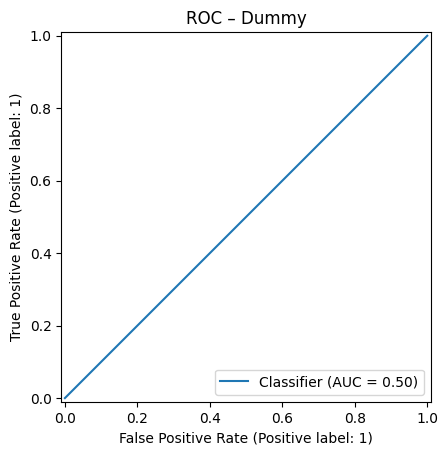

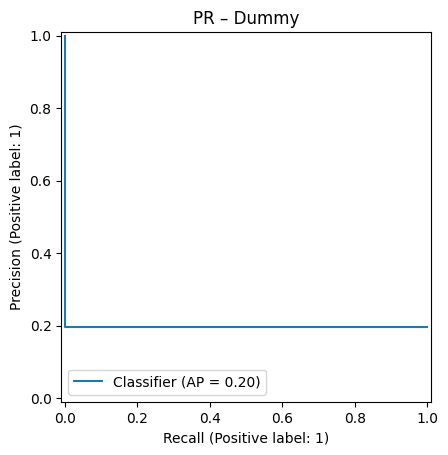


=== LogisticRegression (best) ===
PR-AUC: 0.3921 | ROC-AUC: 0.7781
F1: 0.4649
Matriz de confusão:
[[3636  964]
 [ 493  633]]

Relatório:
               precision    recall  f1-score   support

           0     0.8806    0.7904    0.8331      4600
           1     0.3964    0.5622    0.4649      1126

    accuracy                         0.7455      5726
   macro avg     0.6385    0.6763    0.6490      5726
weighted avg     0.7854    0.7455    0.7607      5726



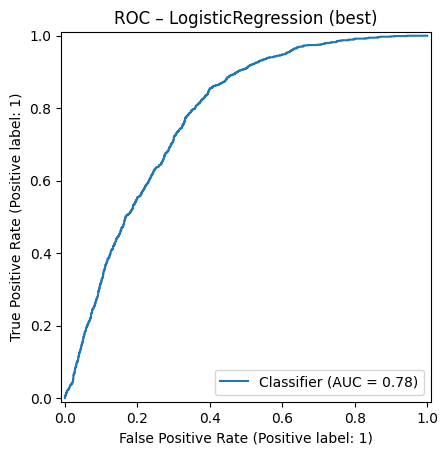

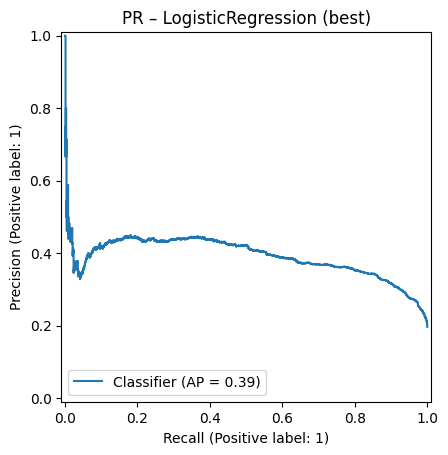


=== SGD (best) ===
PR-AUC: 0.4129 | ROC-AUC: 0.7812
F1: 0.4696
Matriz de confusão:
[[3660  940]
 [ 492  634]]

Relatório:
               precision    recall  f1-score   support

           0     0.8815    0.7957    0.8364      4600
           1     0.4028    0.5631    0.4696      1126

    accuracy                         0.7499      5726
   macro avg     0.6421    0.6794    0.6530      5726
weighted avg     0.7874    0.7499    0.7643      5726



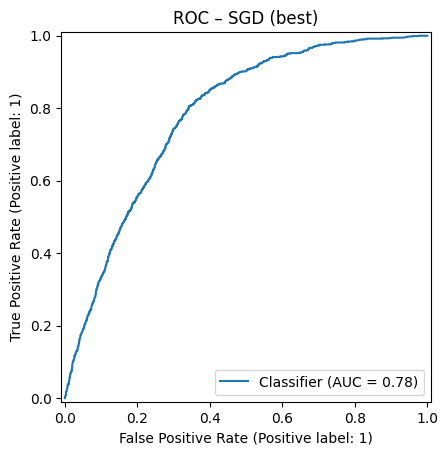

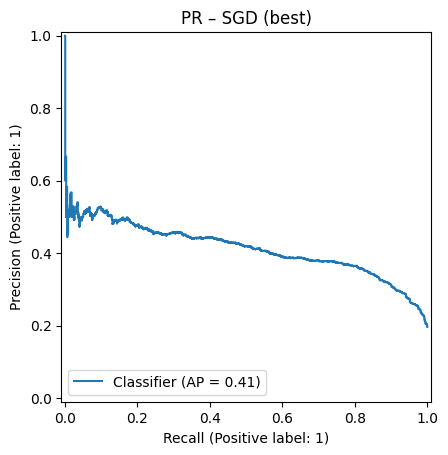

,name,f1,roc_auc,pr_auc
0,Dummy,0.000000,0.500000,0.196647
1,LogisticRegression (best),0.464928,0.778117,0.392055
2,SGD (best),0.469630,0.781242,0.412926


from matplotlib import pyplot as plt
_df_0['f1'].plot(kind='hist', bins=20, title='f1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['roc_auc'].plot(kind='hist', bins=20, title='roc_auc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['pr_auc'].plot(kind='hist', bins=20, title='pr_auc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='f1', y='roc_auc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='roc_auc', y='pr_auc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['f1']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'f1'}, axis=1)
              .sort_values('f1', ascending=True))
  xs = counted['f1']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('f1', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('name')):
  _plot_series(series, series_name, i)
  fig.legend(title='name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('f1')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['roc_auc']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'roc_auc'}, axis=1)
              .sort_values('roc_auc', ascending=True))
  xs = counted['roc_auc']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('roc_auc', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('name')):
  _plot_series(series, series_name, i)
  fig.legend(title='name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('roc_auc')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['pr_auc']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'pr_auc'}, axis=1)
              .sort_values('pr_auc', ascending=True))
  xs = counted['pr_auc']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('pr_auc', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('name')):
  _plot_series(series, series_name, i)
  fig.legend(title='name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('pr_auc')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['f1'].plot(kind='line', figsize=(8, 4), title='f1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['roc_auc'].plot(kind='line', figsize=(8, 4), title='roc_auc')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['pr_auc'].plot(kind='line', figsize=(8, 4), title='pr_auc')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='f1', y='name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='roc_auc', y='name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='pr_auc', y='name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [9]:
# ==== Baseline ====
dummy = Pipeline([('prep', preprocess_A),
                  ('clf', DummyClassifier(strategy='most_frequent'))])
dummy.fit(X_train_A, y_train)

# ==== Logistic Regression (tuning) ====
gkf = GroupKFold(n_splits=5)
log_reg = Pipeline([('prep', preprocess_A),
                    ('clf', LogisticRegression(
                        solver='saga', max_iter=500, n_jobs=-1, class_weight='balanced', random_state=SEED
                    ))])
param_lr = {'clf__C': np.logspace(-2, 2, 20)}
search_lr = RandomizedSearchCV(log_reg, param_lr, n_iter=12, scoring='average_precision',
                               cv=gkf.split(X_train_A, y_train, groups=groups),
                               random_state=SEED, n_jobs=-1, verbose=1)
search_lr.fit(X_train_A, y_train)
best_lr = search_lr.best_estimator_

# ==== SGD (tuning) ====
sgd = Pipeline([('prep', preprocess_A),
                ('clf', SGDClassifier(loss='log_loss', penalty='l2', class_weight='balanced', random_state=SEED))])
param_sgd = {'clf__alpha': np.logspace(-6, -2, 12),
             'clf__penalty': ['l2','l1','elasticnet']}
search_sgd = RandomizedSearchCV(sgd, param_sgd, n_iter=15, scoring='average_precision',
                                cv=gkf.split(X_train_A, y_train, groups=groups),
                                random_state=SEED, n_jobs=-1, verbose=1)
search_sgd.fit(X_train_A, y_train)
best_sgd = search_sgd.best_estimator_

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    pr_auc  = average_precision_score(y_test, y_proba) if y_proba is not None else np.nan
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n=== {name} ===")
    if y_proba is not None:
        print(f"PR-AUC: {pr_auc:.4f} | ROC-AUC: {roc_auc:.4f}")
    print(f"F1: {f1:.4f}\nMatriz de confusão:\n{cm}")
    print("\nRelatório:\n", classification_report(y_test, y_pred, digits=4))
    if y_proba is not None:
        RocCurveDisplay.from_predictions(y_test, y_proba); plt.title(f"ROC – {name}"); plt.show()
        PrecisionRecallDisplay.from_predictions(y_test, y_proba); plt.title(f"PR – {name}"); plt.show()
    return {'name': name, 'f1': f1, 'roc_auc': roc_auc, 'pr_auc': pr_auc}

results_A = []
results_A.append(evaluate_model("Dummy", dummy, X_test_A, y_test))
results_A.append(evaluate_model("LogisticRegression (best)", best_lr, X_test_A, y_test))
results_A.append(evaluate_model("SGD (best)", best_sgd, X_test_A, y_test))

pd.DataFrame(results_A)


## 8) Análise Estatística Ampliada (usando `Rank`, `Result`, `Sec/Mtr/Pts`)

> **Objetivo:** caracterizar e explicar o comportamento dos resultados. Aqui **podemos usar** `Rank`, `Result` e `Sec/Mtr/Pts`, pois não é modelagem preditiva prospectiva, e sim **análise pós-evento**.

Inclui:
- **Comparações de distribuição** (boxplots, histogramas).  
- **Testes não paramétricos**: *Mann–Whitney U* (medalha vs. não), *Kruskal–Wallis* (N, B, S, G).  
- **Tamanhos de efeito**: *Cohen’s d* (aprox.), *Cliff’s delta* (robusto).  
- **Correlação de Spearman** entre variáveis numéricas, incluindo `Rank` e `Sec/Mtr/Pts`.


Mann–Whitney (Sec/Mtr/Pts: medal vs não): U=55077936.5, p=1.14e-139
Cohen's d: -0.324 | Cliff's δ: -0.202
Mann–Whitney (Rank: medal vs não): U=2261869.5, p=0.00e+00
Cohen's d: -1.078 | Cliff's δ: -0.968
Kruskal–Wallis (Sec/Mtr/Pts ~ MedalCat): H=677.17, p=1.87e-146
Correlação de Spearman (numéricos):
                  Age  # Participants  # Countries  # Continents   year  \
Age             1.000          -0.271       -0.274        -0.198  0.083   
# Participants -0.271           1.000        0.933         0.609  0.016   
# Countries    -0.274           0.933        1.000         0.651 -0.017   
# Continents   -0.198           0.609        0.651         1.000 -0.141   
year            0.083           0.016       -0.017        -0.141  1.000   
home_adv        0.004          -0.194       -0.283        -0.198  0.091   
Rank           -0.230           0.698        0.659         0.434  0.074   
Sec/Mtr/Pts    -0.120           0.007        0.019        -0.034  0.025   

                home_a

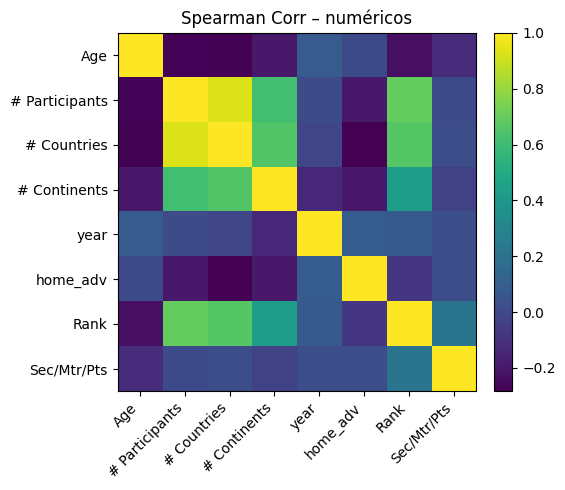

In [10]:
# ==== Funções auxiliares: tamanhos de efeito ====
def cohens_d(x, y):
    x = np.asarray(x); y = np.asarray(y)
    x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2: return np.nan
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    s = np.sqrt(((nx-1)*vx + (ny-1)*vy) / (nx+ny-2))
    return (x.mean() - y.mean()) / s if s > 0 else np.nan

def cliffs_delta(x, y):
    x = np.asarray(x); y = np.asarray(y)
    x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
    n1, n2 = len(x), len(y)
    if n1==0 or n2==0: return np.nan
    # Comparações pareadas
    gt = sum((xi > yi) for xi in x for yi in y)
    lt = sum((xi < yi) for xi in x for yi in y)
    return (gt - lt) / (n1 * n2)

# ==== Medalha vs Não: testes em Sec/Mtr/Pts e Rank ====
if 'Sec/Mtr/Pts' in df.columns:
    s_med = df.loc[df['medal_bin']==1, 'Sec/Mtr/Pts'].dropna()
    s_nom = df.loc[df['medal_bin']==0, 'Sec/Mtr/Pts'].dropna()
    if len(s_med)>0 and len(s_nom)>0:
        U, p = stats.mannwhitneyu(s_med, s_nom, alternative='two-sided')
        print("Mann–Whitney (Sec/Mtr/Pts: medal vs não): U=%.1f, p=%.2e" % (U, p))
        print("Cohen's d:", round(cohens_d(s_med, s_nom),3), "| Cliff's δ:", round(cliffs_delta(s_med, s_nom),3))

if 'Rank' in df.columns:
    r_med = df.loc[df['medal_bin']==1, 'Rank'].dropna()
    r_nom = df.loc[df['medal_bin']==0, 'Rank'].dropna()
    if len(r_med)>0 and len(r_nom)>0:
        U, p = stats.mannwhitneyu(r_med, r_nom, alternative='two-sided')
        print("Mann–Whitney (Rank: medal vs não): U=%.1f, p=%.2e" % (U, p))
        print("Cohen's d:", round(cohens_d(r_med, r_nom),3), "| Cliff's δ:", round(cliffs_delta(r_med, r_nom),3))

# ==== Kruskal–Wallis por 4 categorias de Medalha ====
if 'Sec/Mtr/Pts' in df.columns:
    groups = [df.loc[df['MedalCat']==c, 'Sec/Mtr/Pts'].dropna().values for c in ['N','B','S','G'] if (df['MedalCat']==c).any()]
    if len(groups) >= 2:
        H, p = stats.kruskal(*groups)
        print("Kruskal–Wallis (Sec/Mtr/Pts ~ MedalCat): H=%.2f, p=%.2e" % (H, p))

# ==== Correlação de Spearman entre numéricos ====
num_cols = []
for c in ['Age','# Participants','# Countries','# Continents','year','home_adv','Rank','Sec/Mtr/Pts']:
    if c in df.columns:
        num_cols.append(c)
if len(num_cols) >= 2:
    corr = df[num_cols].corr(method='spearman')
    print("Correlação de Spearman (numéricos):")
    print(corr.round(3))

    # Heatmap simples (matplotlib)
    fig = plt.figure(figsize=(6,5))
    im = plt.imshow(corr, interpolation='nearest')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(ticks=np.arange(len(num_cols)), labels=num_cols, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(num_cols)), labels=num_cols)
    plt.title('Spearman Corr – numéricos')
    plt.tight_layout(); plt.show()


## 9) Trilha B – **Diagnóstico pós-evento** (com vazamento, *não* usar para predição real)

> **Propósito:** quantificar **quanto** `Rank` e `Sec/Mtr/Pts` “explicam” a medalha.  
> **Atenção:** como essas variáveis são consequência do evento, usar no treino/validação **quebra** o pressuposto de predição a priori e inflará métricas.  
> Use esta seção como **análise explicativa** para o relatório (com o devido aviso).

**Features usadas aqui:** `Rank`, `Sec/Mtr/Pts` **+** (opcionalmente) as preditoras a priori.  
Avaliação nas mesmas dobras e teste temporal (apenas para evidenciar o fenômeno).


Fitting 5 folds for each of 10 candidates, totalling 50 fits

=== LR (com Rank & Sec/Mtr/Pts) ===
PR-AUC: 0.9421 | ROC-AUC: 0.9900
F1: 0.8309
Matriz de confusão:
[[4153  447]
 [   8 1118]]

Relatório:
               precision    recall  f1-score   support

           0     0.9981    0.9028    0.9481      4600
           1     0.7144    0.9929    0.8309      1126

    accuracy                         0.9205      5726
   macro avg     0.8562    0.9479    0.8895      5726
weighted avg     0.9423    0.9205    0.9250      5726



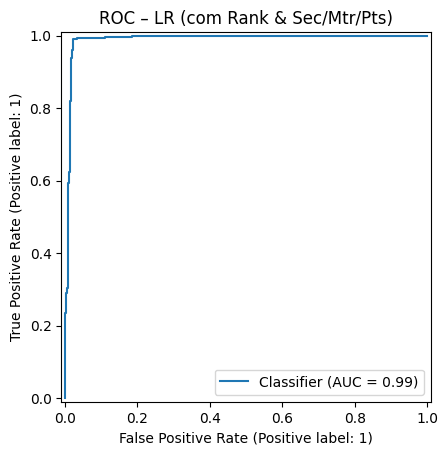

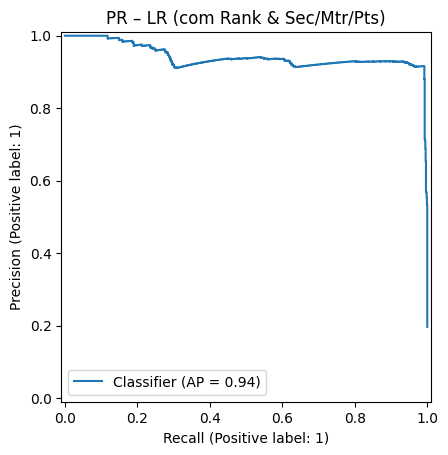

,name,f1,roc_auc,pr_auc
0,LR (com Rank & Sec/Mtr/Pts),0.830918,0.989965,0.942084


In [14]:
# ==== Trilha B: inclui Rank e Sec/Mtr/Pts ====
FEATURES_B = FEATURES_A.copy()
for extra in ['Rank','Sec/Mtr/Pts']:
    if extra in df.columns and extra not in FEATURES_B:
        FEATURES_B.append(extra)

X_train_B = train_df[FEATURES_B].copy()
X_test_B  = test_df[FEATURES_B].copy()

# Separar listas num/cat de B
numeric_B = [c for c in numeric_A] + [c for c in ['Rank','Sec/Mtr/Pts'] if c in FEATURES_B]
categorical_B = [c for c in categorical_A]

preprocess_B = ColumnTransformer([('num', SimpleImputer(strategy='median'), numeric_B),
                                  ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                                                    ('ohe', OneHotEncoder(handle_unknown='ignore'))]), categorical_B)])

lr_B = Pipeline([('prep', preprocess_B),
                 ('clf', LogisticRegression(
                     solver='saga', max_iter=500, n_jobs=-1, class_weight='balanced', random_state=SEED
                 ))])

param_lr_B = {'clf__C': np.logspace(-2, 2, 20)}

# Redefine groups to match the samples in X_train_B
groups_B = X_train_B.index

search_lr_B = RandomizedSearchCV(lr_B, param_lr_B, n_iter=10, scoring='average_precision',
                                 cv=GroupKFold(n_splits=5).split(X_train_B, y_train, groups=groups_B),
                                 random_state=SEED, n_jobs=-1, verbose=1)
search_lr_B.fit(X_train_B, y_train)
best_lr_B = search_lr_B.best_estimator_

res_B = []
res_B.append(evaluate_model("LR (com Rank & Sec/Mtr/Pts)", best_lr_B, X_test_B, y_test))
pd.DataFrame(res_B)

## 10) Regressão de `Sec/Mtr/Pts` com variáveis **pré-evento**

> Tarefa distinta: prever o **tempo (s)** da prova **antes** da competição.  
> **Modelos:** `DummyRegressor` (baseline) e `Ridge` (linear).  
> **Métricas:** MAE, RMSE e R², avaliadas no **teste temporal**.  
> *Limitações*: sem PB/SB do atleta, país/ano capturam parte do contexto mas não performance individual.


In [16]:
# ==== Regressão (pré-evento) ====
if 'Sec/Mtr/Pts' in df.columns:
    y_train_reg = train_df['Sec/Mtr/Pts'].values
    y_test_reg  = test_df['Sec/Mtr/Pts'].values

    # Filtrar casos com alvo conhecido
    mask_tr = ~np.isnan(y_train_reg)
    mask_te = ~np.isnan(y_test_reg)
    Xtr_reg = train_df.loc[mask_tr, FEATURES_A].copy()
    ytr_reg = y_train_reg[mask_tr]
    Xte_reg = test_df.loc[mask_te, FEATURES_A].copy()
    yte_reg = y_test_reg[mask_te]

    pre_reg = preprocess_A  # mesmo preprocessador
    dummy_r = Pipeline([('prep', pre_reg), ('reg', DummyRegressor(strategy='median'))])
    ridge   = Pipeline([('prep', pre_reg), ('reg', Ridge(random_state=SEED))])

    dummy_r.fit(Xtr_reg, ytr_reg)
    ridge.fit(Xtr_reg, ytr_reg)

    def eval_reg(name, model, X, y):
        pred = model.predict(X)
        mae = mean_absolute_error(y, pred)
        mse = mean_squared_error(y, pred) # Calculate MSE
        rmse = np.sqrt(mse) # Calculate RMSE from MSE
        r2 = r2_score(y, pred)
        print(f"{name}: MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")
        return {'name': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

    print("\n=== Avaliação Regressão (teste temporal) ===")
    reg_res = []
    reg_res.append(eval_reg("DummyRegressor", dummy_r, Xte_reg, yte_reg))
    reg_res.append(eval_reg("Ridge", ridge, Xte_reg, yte_reg))
    pd.DataFrame(reg_res)
else:
    print("Coluna 'Sec/Mtr/Pts' ausente; regressão não foi executada.")


=== Avaliação Regressão (teste temporal) ===
DummyRegressor: MAE=3.528 | RMSE=4.955 | R²=-0.012
Ridge: MAE=1.431 | RMSE=3.105 | R²=0.602


## 11) Checklist – Respostas Diretas

**Definição do Problema:** Seções 1 e 7 (Trilha A) – classificar medalha usando variáveis a priori.  
**Preparação de Dados:** Seções 4–6 – limpeza, `event_id`, split temporal, GroupKFold.  
**Modelagem e Treinamento:** Seção 7 – baselines, tuning, comparação; Seção 10 – regressão.  
**Avaliação de Resultados:** Seções 7, 8 e 9 – métricas adequadas; análise diagnóstica (Trilha B) com aviso de vazamento.  
**Conclusões:** Seção 12 – limitações e próximos passos.


## 12) Conclusões e Próximos Passos

- **Sem vazamento (Trilha A):** modelos lineares com OHE oferecem baseline honesta; desbalanceamento torna **PR‑AUC** essencial.  
- **Diagnóstico (Trilha B):** incluir `Rank`/`Sec/Mtr/Pts` **infla métricas** por se tratar de **pós-evento** – útil apenas para **explicação**.  
- **Regressão:** prever `Sec/Mtr/Pts` somente com contexto é difícil; ganhos virão de **dados de performance individual** (PB/SB), *features* por país/ano e modelos de _boosting_.  
- **Próximos passos:** (i) adicionar métricas do(a) atleta; (ii) experimentar `XGBoost`/`LightGBM`; (iii) modelagem **multiclasse** (N, B, S, G) com abordagem **ordinal**; (iv) calibrar limiares por **competição**.
